In [101]:
import graphAlgorithms as ga

Here we want to compare two networks in detail in order to investigate if specific nodes (genes) / gene areas are changing/ are affected by the condition.

# Load Networks



In [2]:
#location where the raw data files are stored
# TODO: change to package location & select the 2 example networks directly by name
graph_location = "/mnt/data/apavel/graphalgo/testset/"

#location where output should be saved
location = "/mnt/data/apavel/graphalgo/testoutput/"

below an example on how to load an Edgelist with column headings into a NetworkX Graph object


In [3]:
import glob
import pandas as pd
import networkx as nx
import numpy as np

In [4]:

labels = []
networks_graphs = []
cnt = 0
print("load networks")
#gets all files located in the specified folder that end on .edgelist
for path in glob.glob(graph_location +"*.edgelist"):
    if cnt < 2:
        #you can specify that only part of the file name should be used as network name for later identification
        name =  path.split("/")[-1].replace(".rds.edgelist", "")


        #read the edgelist file as a dataframe
        fh = pd.read_csv(path, sep="\t")
        #convert it into a NetworkX graph G and specify the column names of the node pairs
        G=nx.from_pandas_edgelist(fh, "V1", "V2")

        #if you have an unweighted network assign all edges the same edge weight - here a value of 1 is assigned
        for u, v, d in G.edges(data=True):
            d['weight'] = 1


        #save the graph objects to a list (only suitable if small networks are processed)
        #this is the main objects used for the examples below, which contains all networks
        networks_graphs.append(G)
        labels.append(name)




        print("loaded", name)
    cnt = cnt + 1

load networks
loaded lestaurtinib
loaded labetalol


convert the networks into the used format

In [5]:
networks = ga.get_node_similarity.preprocess_graph(networks_graphs, attribute="weight")

get union of all nodes 

In [6]:
nodes = []
for net in networks_graphs:
    for node in net.nodes():
        if node not in nodes:
            nodes.append(node)

mapp node names to ID (this is mainly used for node & edge similarity functions)

In [7]:
network_lists, mapping = ga.get_node_similarity.preprocess_node_list(networks)

save mapping for later

In [8]:
import pickle

with open(location + "node_id_mapping_network_network.pckl", "wb") as f:
    pickle.dump(mapping, f, protocol=4)

OPTIONAL: create reversed mapping object

In [9]:
reverse_mapping = ga.distances.node_edge_similarities.reverse_node_edge_mapping(mapping)

# Nodes

we compare based on different centrality measures how the node location in the network changes and which nodes are the most similar or most different ones.
Here we make use of the centrality ranks (as also estimated in the Network clustering pipeline).

In [17]:
sorted_nodes = []

for graph in networks_graphs:
    temp = ga.distances.node_edge_similarities.sort_node_list(graph, mapping, degree_centrality=True, closeness_centrality=True, betweenness=True, k=None, as_str=False)
    
    sorted_nodes.append(temp)

1
2
3
average position is calculated
1
2
3
average position is calculated


In [14]:
sorted_nodes[0][0].keys()

dict_keys(['degree', 'dc', 'cc', 'betweenness', 'average_mean', 'average_median'])

convert dict output to a dataframe to be more human readable

In [19]:
mapping_ids = list(mapping.values())

In [27]:
import pandas as pd 

df = pd.DataFrame(mapping_ids, 
               columns =['Mapping ID']) 

In [34]:
# add the reversed mapping IDS (original node IDs - here they are Entrez IDs)
entrez = []
for g in mapping_ids:
    entrez.append(reverse_mapping[g])
df["Entrez IDs"] = entrez

In [29]:
for i in range(len(sorted_nodes)):
    item = sorted_nodes[i][0]
    for key in item.keys():
        #ignore "degree" key, since it has not been calculated. We are using degree centrality instead.
        if key != "degree":
            temp = []
            for g in mapping_ids:
                temp.append(item[key][g])
                
            #add to dataframe
            #since the results are in the same order as the network labels 
            #we can use the network label directly as column heading
            df[labels[i]+" Ranking " + key] = temp


In [35]:
df

,Mapping ID,Entrez IDs,lestaurtinib Ranking dc,lestaurtinib Ranking cc,lestaurtinib Ranking betweenness,lestaurtinib Ranking average_mean,lestaurtinib Ranking average_median,labetalol Ranking dc,labetalol Ranking cc,labetalol Ranking betweenness,labetalol Ranking average_mean,labetalol Ranking average_median
0,0,780,326,2,89,973,956,82,525,797,508,508
1,1,2114,329,3,270,786,800,649,82,218,878,878
2,2,6659,342,4,172,785,786,370,370,525,592,940
3,3,664,330,6,167,976,973,245,674,347,940,592
4,4,26064,334,8,58,975,976,674,751,638,435,435
...,...,...,...,...,...,...,...,...,...,...,...,...
972,972,23038,969,947,723,219,50,766,332,435,210,643
973,973,10273,970,948,785,341,339,435,878,592,525,674
974,974,10589,973,949,786,334,219,940,968,940,674,370
975,975,3202,800,971,800,340,58,878,592,878,643,525


We are interessted in knowing which genes change the most between the networks with regards to their network position. Therefore we are going to estimate the rank difference of the median ranks.
This can be done for any of the other parameters as well if it is needed for your analysis in the same way.

In [31]:
change = []

for g in mapping_ids:
    
    val1 = df.loc[df["Mapping ID"] == g]["lestaurtinib Ranking average_median"].to_list()[0]
    
    val2 = df.loc[df["Mapping ID"] == g]["labetalol Ranking average_median"].to_list()[0]
    
    change.append(abs(val1-val2))

In [48]:
df_change = pd.DataFrame(list(zip(mapping_ids, entrez, change, df["lestaurtinib Ranking average_median"].to_list(), df["labetalol Ranking average_median"].to_list())), 
               columns =['Mapping ID', 'Entrez IDs', 'Absolute Ranking Difference', 'lestaurtinib Ranking average_median', 'labetalol Ranking average_median' ]) 

Sort the dataframe

In [53]:
df_change = df_change.sort_values(by =["Absolute Ranking Difference"], axis=0, ascending=False)

The 20 top genes, which network position changes the most

In [55]:
df_change.head(20)

,Mapping ID,Entrez IDs,Absolute Ranking Difference,lestaurtinib Ranking average_median,labetalol Ranking average_median
8,8,8518,967,974,7
556,556,831,926,25,951
150,150,54555,910,918,8
309,309,51024,909,960,51
174,174,3300,905,940,35
70,70,147179,898,74,972
167,167,976,893,29,922
148,148,54850,892,920,28
952,952,7398,885,3,888
685,685,2745,885,41,926


The 20 top most similar genes, with regards to their network position

In [56]:
df_change.tail(20)

,Mapping ID,Entrez IDs,Absolute Ranking Difference,lestaurtinib Ranking average_median,labetalol Ranking average_median
865,865,2356,11,810,821
661,661,23335,11,384,395
790,790,10613,10,467,457
109,109,10810,10,379,369
335,335,10250,9,26,17
379,379,4925,8,600,608
6,6,10123,7,975,968
317,317,3978,7,730,737
718,718,64080,7,566,559
773,773,23161,6,82,88


These genes could now for example be functionally enriched or a GSEA could be performed on them (combined or individually).

TODO? Should enrichment be done externally or should we include e.g. the API call to the panther enrichment tool? or simply show the code here?

# Edges

Which edges are common in the 2 networks, which edges are unique to one network. And which edges network position (betweenness) changes the most?

Estimate edge betweenness scores and assign them to the graph objects

In [40]:
print("sort edges after edge betweenness")
bet = []
graphs_with_betweenness = []
for net in networks_graphs:
    edges_betweenness = nx.edge_betweenness_centrality(net)
    bet.append(edges_betweenness)
    #write as new attribute to graph
    temp = nx.set_edge_attributes(net, edges_betweenness, "betweenness")

sort edges after edge betweenness


convert the networks & map edges to IDs

In [41]:
networks = ga.get_edge_similarity.preprocess_graph(networks_graphs, attribute="betweenness")

print("map edges to id")

network_lists, mapping = ga.get_edge_similarity.preprocess_edge_list(networks)

with open(location + "edge_id_mapping_network_network.pckl", "wb") as f:
    pickle.dump(mapping, f, protocol=4)

map edges to id


In [42]:
reverse_mapping = ga.distances.node_edge_similarities.reverse_node_edge_mapping(mapping)

Get shared edges. Returns a dict, where key is mapped edge ID and value is list of network names this edge is present in.

In [43]:
shared = ga.distances.node_edge_similarities.compute_shared_layers(network_lists, labels, is_file=False, in_async=False)

lestaurtinib
labetalol


convert to a dataframe to be more human readable

In [44]:
edges = list(reverse_mapping.values())
edge_mapped_IDs = list(reverse_mapping.keys())

df = pd.DataFrame(list(zip(edges, edge_mapped_IDs)), 
               columns =['Edges', 'Mapping ID']) 
    

In [45]:
for label in labels:
    temp = []
    for i in edge_mapped_IDs:
        if label in shared[i]:
            temp.append(1)
        else:
            temp.append(0)
            
    df["In "+label] = temp
    

In [46]:
df

,Edges,Mapping ID,In lestaurtinib,In labetalol
0,"2114,780",0,1,0
1,"6659,780",1,1,0
2,"664,780",2,1,0
3,"26064,780",3,1,0
4,"1514,780",4,1,0
...,...,...,...,...
29744,"1017,55152",29744,0,1
29745,"65057,8518",29745,0,1
29746,"51001,54512",29746,0,1
29747,"29940,5526",29747,0,1


Select all edges that are in both

In [47]:
shared_df = df.loc[(df["In lestaurtinib"] == 1) & (df["In labetalol"] == 1)]

In [48]:
shared_df

,Edges,Mapping ID,In lestaurtinib,In labetalol
33,"51742,780",33,1,1
37,"7296,2114",37,1,1
68,"1955,2114",68,1,1
76,"8996,2114",76,1,1
96,"11230,6659",96,1,1
...,...,...,...,...
17116,"10318,3028",17116,1,1
17131,"23585,10559",17131,1,1
17157,"771,1994",17157,1,1
17199,"54851,771",17199,1,1


For example you can now functional enrich the genes making up the consistent edges. Or see if this edges belong to some specific modules in the network.

Select unique edges

In [49]:
unique_df = df.loc[((df["In lestaurtinib"] == 1) & (df["In labetalol"] == 0)) | ((df["In lestaurtinib"] == 0) & (df["In labetalol"] == 1))]

In [50]:
unique_df

,Edges,Mapping ID,In lestaurtinib,In labetalol
0,"2114,780",0,1,0
1,"6659,780",1,1,0
2,"664,780",2,1,0
3,"26064,780",3,1,0
4,"1514,780",4,1,0
...,...,...,...,...
29744,"1017,55152",29744,0,1
29745,"65057,8518",29745,0,1
29746,"51001,54512",29746,0,1
29747,"29940,5526",29747,0,1


TODO: enrichment / mapping to modules?

# Node areas/ connectivity

which nodes are connected in a similar way and which node areas are different?

## Random walks

For each common node in the 2 networks random walks are performed and their similarity in visited nodes is compared. This allows to identify the most similar/ dissimilar node areas.

For each node 10 * its degree random walks of size 5 are performed. A smaller walk size "scans" a smaller area around the starting node.

In [93]:
performed_walks = ga.get_walk_distances.helper_walks(networks_graphs, nodes, labels, steps=5, number_of_walks=10, degree=True, probabilistic=False, weight ="weight")

walks for node  0 outof 977
running walks 370 for node 780
running walks 180 for node 780
running walks 420 for node 2114
running walks 160 for node 2114
running walks 540 for node 6659
running walks 390 for node 6659
running walks 540 for node 664
running walks 170 for node 664
running walks 540 for node 26064
running walks 270 for node 26064
running walks 420 for node 1514
running walks 380 for node 1514
running walks 540 for node 10123
running walks 540 for node 10123
running walks 130 for node 10444
running walks 30 for node 10444
running walks 540 for node 8518
running walks 120 for node 8518
running walks 120 for node 10450
running walks 140 for node 10450
running walks 540 for node 2542
running walks 290 for node 2542
running walks 270 for node 1429
running walks 270 for node 1429
running walks 350 for node 3566
running walks 550 for node 3566
running walks 350 for node 8624
running walks 180 for node 8624
running walks 350 for node 10732
running walks 540 for node 10732
running

Now we are estimating for each starting node how often surrounding nodes/ edges have been visit w.r.t. all the visited nodes/ edges. Depending on your network sizes and selected nodes this can be quite memory intensive.

In [94]:
node_counts, edge_counts, nodes_frc, edges_frc = ga.get_walk_distances.helper_get_counts(labels, networks_graphs, performed_walks)

Now we want to estimate network similarities based on the visited nodes. For each network pair, kendall rank correlation is calculated (of the top 20 nodes) for the same starting node. The mean correlation value of all same node pairs for a network pair is estimated as well as the individual values are calculated and returned.

In [95]:
results_edges, results_nodes, results_edges_p, results_nodes_p, results_edges_all, results_nodes_all, results_edges_p_all, results_nodes_p_all = ga.get_walk_distances.helper_walk_sim(networks_graphs, performed_walks, nodes, labels, top=20, undirected=False, return_all = True, nodes_ranked=nodes_frc, edges_ranked=edges_frc)

n1 lestaurtinib
n2 lestaurtinib
n1 lestaurtinib
n2 labetalol
n1 labetalol
n2 labetalol


In [96]:
#map results to a dataframe
df = pd.DataFrame(list(zip(nodes, results_nodes_all[('lestaurtinib', 'labetalol')])), 
               columns =['Entrez ID', 'Correlation']) 

#sort after correlation

df = df.sort_values(by =["Correlation"], axis=0, ascending=False)

In [97]:
df.head(20)

,Entrez ID,Correlation
797,1802,0.494737
521,29082,0.484211
209,1017,0.473684
487,27333,0.442105
558,323,0.431579
288,8444,0.431579
640,55890,0.431579
636,57149,0.421053
318,10237,0.421053
325,3964,0.410526


In [98]:
df.tail(20)

,Entrez ID,Correlation
300,60493,-0.284211
915,4125,-0.284211
528,9246,-0.294737
462,6845,-0.294737
824,8800,-0.294737
847,5831,-0.294737
719,9217,-0.305263
493,23200,-0.305263
578,29890,-0.305263
402,22841,-0.315789


TODO: Nodes in this areas can again be functionally enriched and/ or their modules can be investigated.

Probabable remove from here on!!!!!!

# Community/ Module detection

We will detect modules in the graphs and map the previously identified similar/ dissimilar areas to them.
Here we will only use a simple community detection method. For more algorithms, evaluation and ensembl methods please refer to the Community notebook.

For the example the walktrap algorithm is used, which is based on non probabilistic random walks.

In [10]:
communities = []

for graph in networks_graphs:
    c = ga.communities.walktrap(graph, return_object=False)
    #convert into another format
    con = ga.communities.convert_communities(c)
    
    communities.append(con)

How similar are the detected communities/ modules w.r.t their nodes?

To answer this we transform each community into a subgraph and compare their nodes (if they have at least 1 edge).
For similar modules the edges can be compared as well.

In [30]:
subgraphs = []
com_labels = []
for i in range(len(communities)):
    com = communities[i]
    graph = networks_graphs[i]
    
    for k in com.keys():
        if len(graph.subgraph(com[k]).edges()) > 1:
            subgraphs.append(graph.subgraph(com[k]))
       
            com_labels.append(labels[i]+"_"+str(k))

Following are the same functions as applied in the Nodes section in the Network clustering notebook. For explanations refer to this section.


In [31]:
sub_networks = ga.get_node_similarity.preprocess_graph(subgraphs, attribute="weight")

sub_network_lists, sub_mapping = ga.get_node_similarity.preprocess_node_list(sub_networks)

with open(location + "node_id_mapping_subgraphs.pckl", "wb") as f:
    pickle.dump(sub_mapping, f, protocol=4)
    
sorted_nodes, shared_nodes, binary, centrality_values = ga.get_node_similarity.sort_list_and_get_shared(sub_network_lists, sub_mapping, subgraphs, com_labels, degree_centrality=True, closeness_centrality=True, betweenness=True, degree=False, in_async=False)

lestaurtinib_0
lestaurtinib_1
lestaurtinib_2
lestaurtinib_3
lestaurtinib_4
lestaurtinib_5
lestaurtinib_6
lestaurtinib_7
lestaurtinib_8
lestaurtinib_9
lestaurtinib_10
lestaurtinib_11
lestaurtinib_12
lestaurtinib_13
lestaurtinib_14
lestaurtinib_15
lestaurtinib_16
lestaurtinib_17
lestaurtinib_18
lestaurtinib_19
lestaurtinib_20
lestaurtinib_21
labetalol_0
labetalol_1
labetalol_2
labetalol_3
labetalol_4
labetalol_5
labetalol_6
labetalol_7
labetalol_8
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calcul

In [35]:
jd, per = ga.node_edge_similarities.shared_elements_multiple(sub_network_lists, labels=com_labels, percentage=True, jaccard=True, jaccard_similarity=False, in_async=False, is_file=False)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(3, 21)
(3, 22)
(3, 23)
(3, 24)
(3, 25)
(3, 26)
(3, 27)
(3, 28)
(3, 29)
(3, 30)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

Do the communities in the different networks contain similar nodes?

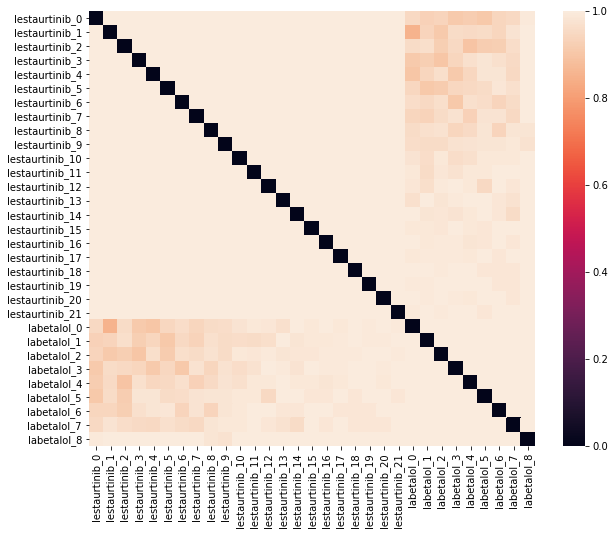

In [38]:
fig, ax = plt.subplots(figsize=(10,8))  

sns.heatmap(jd, annot=False, ax=ax, xticklabels=com_labels, yticklabels=com_labels)

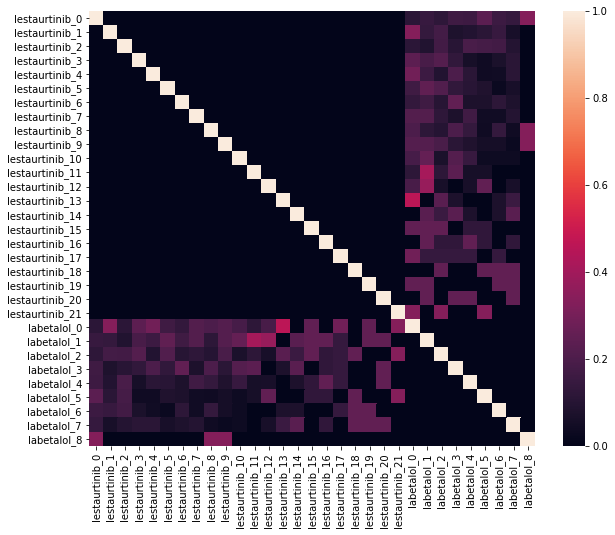

In [39]:
fig, ax = plt.subplots(figsize=(10,8))  

sns.heatmap(per, annot=False, ax=ax, xticklabels=com_labels, yticklabels=com_labels)